In [1]:
import pandas as pd
import numpy as np
np.random.seed(1234)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [35]:
df = pd.read_csv("./bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'BitCoin Price Dynamics')

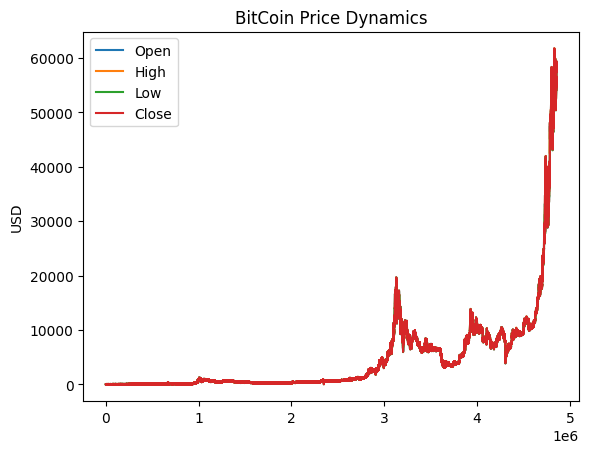

In [79]:
ax = df["Open"].plot(legend=True)
df["High"].plot(axes=ax, legend=True)
df["Low"].plot(axes=ax, legend=True)
df["Close"].plot(axes=ax, legend=True)
ax.set_ylabel("USD")
ax.set_title("BitCoin Price Dynamics")

In [90]:
num = 50
start = int(1e6)
finish = start+num

Text(0.5, 1.0, 'BitCoin Price Dynamics')

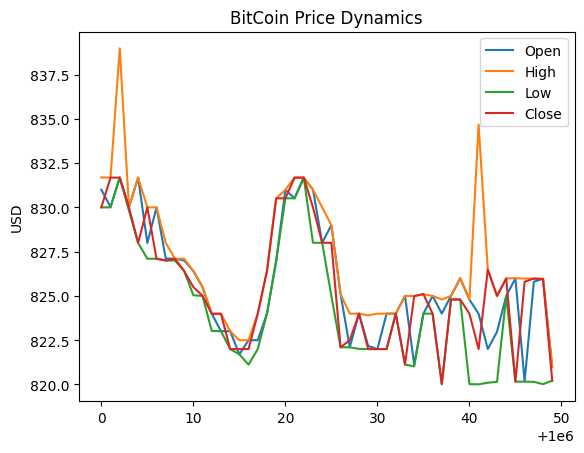

In [91]:
ax = df["Open"][start:finish].plot(legend=True)
df["High"][start:finish].plot(axes=ax, legend=True)
df["Low"][start:finish].plot(axes=ax, legend=True)
df["Close"][start:finish].plot(axes=ax, legend=True)
ax.set_ylabel("USD")
ax.set_title("BitCoin Price Dynamics")

Text(0.5, 1.0, 'BitCoin Open-to-Close Dynamics')

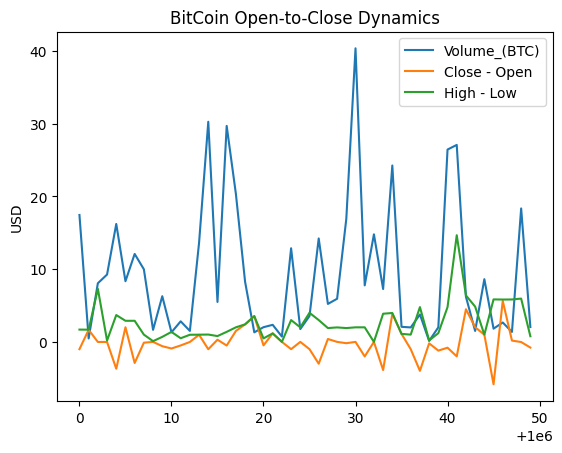

In [92]:
ax = df["Volume_(BTC)"][start:finish].plot(legend=True)
(df["Close"][start:finish]-df["Open"][start:finish]).plot(axes=ax, legend=True, label="Close - Open")
(df["High"][start:finish:]-df["Low"][start:finish:]).plot(axes=ax, legend=True, label="High - Low")
ax.set_ylabel("USD")
ax.set_title("BitCoin Delta Dynamics")

In [94]:
df.shape

(4857377, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


Text(0.5, 1.0, 'Feature Correlation Plot')

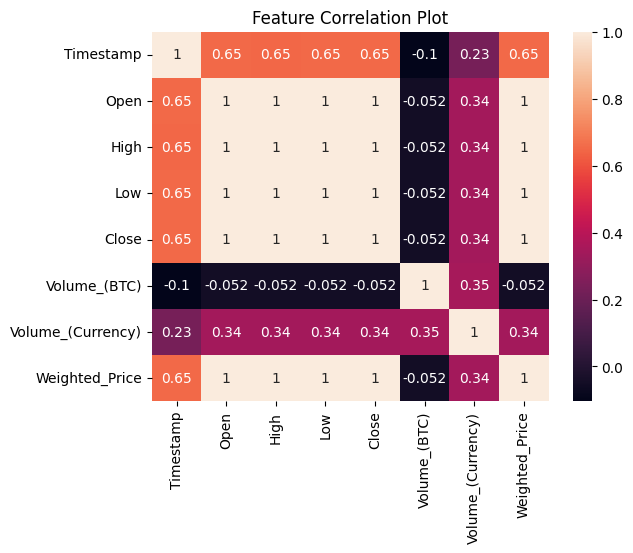

In [5]:
sns.heatmap(df.corr(), annot=True)
plt.title("Feature Correlation Plot")